# Data exploration

This notebook will explore the images we have and extract data from them. The images have 4 channels (DAPI, EdU, and two Alexa's, one being PCNA). The data we extract from the channels are the pixel intensities.

## Importing data

Note: since I'm working from home right now, I'm struggling with my connection to Omero so I'm importing data I saved from earlier. When I'm back in the lab I will change this part to be importing data from Omero with the plate number.

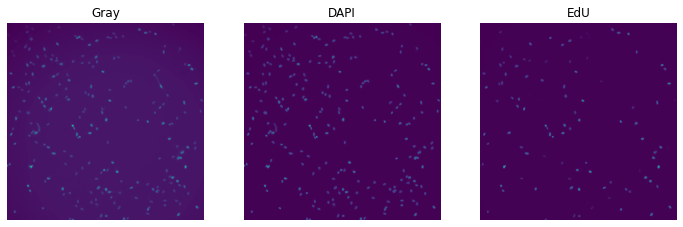

In [6]:
#Here we get the images from a directory in the project and display them

import numpy as np
import matplotlib.pyplot as plt

gray_img = np.load('/Users/rehanzuberi/Documents/Development/cell-SCT/classification/images/gray_img.npy')
dapi_img = np.load('/Users/rehanzuberi/Documents/Development/cell-SCT/classification/images/dapi_img.npy')
edu_img = np.load('/Users/rehanzuberi/Documents/Development/cell-SCT/classification/images/cy5_img.npy')

plt.figure(figsize=(12,12))
plt.subplot(1,3,1);plt.imshow(gray_img);plt.axis('off');plt.title('Gray')
plt.subplot(1,3,2);plt.imshow(dapi_img);plt.axis('off');plt.title('DAPI')
plt.subplot(1,3,3);plt.imshow(edu_img);plt.axis('off');plt.title('EdU');plt.show()

In [15]:
#Make a segmentation prediction, right now with the Gray image as that's all we have, later with the Alexa555 (PCNA) image

from cellpose import models
model_dir = "/Users/rehanzuberi/Documents/Development/cell-SCT/segmentation/demo_train_test_data/data_for_masks_training/models/demo_model"
model = models.CellposeModel(gpu=True, pretrained_model=model_dir)
test_data = [gray_img]
predicted_test_masks = model.eval(test_data, channels=[0,0], diameter=model.diam_labels.copy())[0]  # generates the predictions # we could use the fact that it has a channel input to have the normal image not separated by channel and just make it do the prediction on there, although we need it to make a prediction on the averaged out gray image so that wouldn't really work
predicted_mask = predicted_test_masks[0]

In [88]:
#Now we get the crops from each channel and store them in a numpy array
import segmentation.seg_functions
from importlib import reload
from segmentation.seg_functions import count_cells, get_cell_crop_coordinates, get_img_crops
segmentation.seg_functions = reload(segmentation.seg_functions)

print('Prediction has', count_cells(predicted_mask), 'cells')
crop_coordinates = get_cell_crop_coordinates(predicted_mask, margin=3)
gray_crops = get_img_crops(gray_img, crop_coordinates)
dapi_crops = get_img_crops(dapi_img, crop_coordinates)
edu_crops = get_img_crops(edu_img, crop_coordinates)

#We could have one numpy array called 'cells' that holds the images and later on the values

Prediction has 146 cells


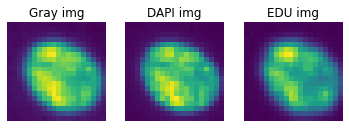

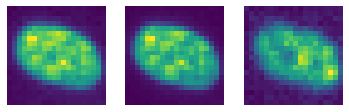

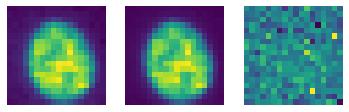

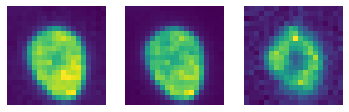

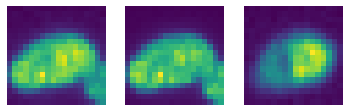

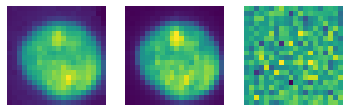

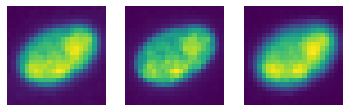

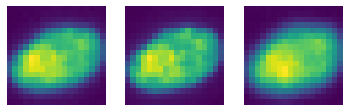

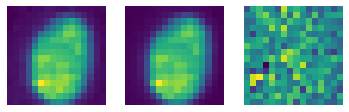

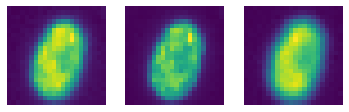

In [89]:
for i in range(10):
    plt.subplot(1,3,1)
    if i == 0: plt.title('Gray img')
    plt.axis('off')
    plt.imshow(gray_crops[i])

    plt.subplot(1,3,2)
    if i == 0: plt.title('DAPI img')
    plt.axis('off')
    plt.imshow(dapi_crops[i])

    plt.subplot(1,3,3)
    if i == 0: plt.title('EDU img')
    plt.imshow(edu_crops[i])
    plt.axis('off')
    plt.show()

In [90]:
#This is what we used to measure the pixel intentisty values of the cells on different channels
#We would put them into one array
#Now I think I would prefer putting them into each their own numpy array
#This also depends on what Helfrid's normalisation funcitions ofers
dapi_values = []
edu_values = []
for i in range(len(edu_crops)):
    dapi_values.append(np.average(dapi_crops[i]))
    edu_values.append(np.average(edu_crops[i]))

dapi_values = np.array(dapi_values)
edu_values = np.array(edu_values)

In [91]:
print(dapi_values)

[ 5269.6175      3957.8275      4646.1882716   4055.1475
  5619.93209877  5234.5525      4980.41115702  7557.59876543
  5832.44921875  3502.34297521  4668.105       3484.77479339
  3276.87396694  3660.93595041  4560.07        7176.79338843
  3999.20454545  4076.50826446  5345.69135802  4083.06818182
  4172.67975207  5565.09567901  6765.37109375  8280.825
  3841.921875    6339.49380165  4815.2775      9362.82098765
  4019.15909091  4514.98140496  4560.06790123  3187.41863905
  4921.1675      5445.43181818  5898.3125      5645.6175
  7965.76171875  4491.87673611  6637.83333333  4556.7175
  5821.96604938  7924.42355372  4240.56423611  5078.19
  5288.71875     4280.9338843   4881.00925926  7087.5390625
  5223.53703704  4911.46        5066.805       5016.5825
  4278.83677686  4715.27066116  5661.0825     12927.90625
  4081.14669421  7539.79958678  3731.86979167  5591.09297521
  6090.9691358   5993.13        4880.19        4431.91115702
  4201.26239669  4968.255       3729.06404959  6002.540

In [92]:
#Helfrid's normalisation function

def dna_norm(df):
    """
    normalise histogram of DNA label
    :param df: input dataframe
    :return: input dataframe with additional column: "DNA_content"
    """
    y, x, _ = plt.hist(df['integrated_int_DAPI'], bins=250)
    max = x[np.where(y == y.max())]
    df['DNA_content']=df['integrated_int_DAPI']/max[0]
    return df

In [93]:
import pandas as pd

#pi: pixel intensity

cell_data = {'Gray cell img':gray_crops, 'integrated_int_DAPI':dapi_values, 'EDU pi':edu_values}
df = pd.DataFrame(cell_data)

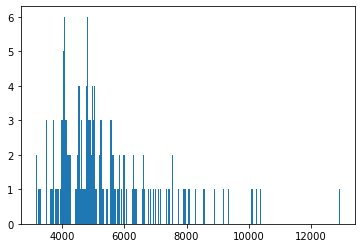

In [94]:
normalised = dna_norm(df)

In [95]:
print(normalised)

                                         Gray cell img  integrated_int_DAPI  \
0    [[1929.5, 1830.0, 1902.5, 1897.25, 1901.25, 19...          5269.617500   
1    [[1993.25, 1940.25, 2048.25, 2016.5, 2037.5, 2...          3957.827500   
2    [[1996.0, 2008.5, 2050.75, 2045.75, 2075.25, 2...          4646.188272   
3    [[2154.0, 2154.5, 2159.75, 2158.0, 2171.25, 21...          4055.147500   
4    [[2046.5, 1992.0, 2005.5, 2111.25, 2118.75, 20...          5619.932099   
..                                                 ...                  ...   
141  [[2579.25, 2581.25, 2515.25, 2557.25, 2514.25,...          3162.954142   
142  [[2624.0, 2649.0, 2642.25, 2622.5, 2666.5, 265...          4805.642500   
143  [[2429.75, 2420.75, 2404.0, 2457.0, 2352.75, 2...          6257.024306   
144  [[2620.0, 2546.25, 2596.0, 2584.75, 2636.0, 27...          3314.396450   
145  [[2530.0, 2465.5, 2448.5, 2451.5, 2548.75, 250...          6603.452381   

          EDU pi  DNA_content  
0    3291.895000   

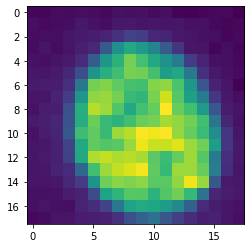

In [96]:
#We need to get the colour of the background for the EdU since not being the same colour of the background gives info
plt.imshow(df.sort_values(by=['EDU pi'])['Gray cell img'][2])

345.3057851239669


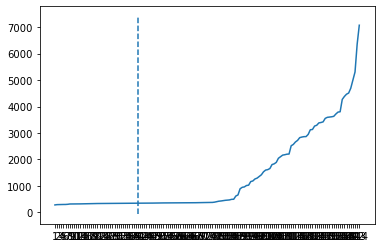

In [227]:
#I'm trying to find the background color in the EdU channel
#Let's try putting the values in buckets
#From this bucket method I would conclude that the background is at 500
from statistics import mean

num_buckets = 144
edu_nums = np.array(df.loc[:,['EDU pi']]).flatten()
edu_nums = np.sort(edu_nums)
edu_nums = np.array_split(edu_nums,num_buckets)
averages = []
for array in edu_nums: averages.append(mean(array))
import matplotlib.pyplot as plt
fig = plt.figure()
bars = [i+1 for i in range(num_buckets)]
y_pos = np.arange(len(bars))
#plt.bar(y_pos, averages)
plt.plot(averages)
#plt.yticks([i for i in range(0,5000,250)])
plt.xticks(y_pos, bars)
#plt.grid('on')


#Need to fid the elbow
#from kneed import KneeLocator
#kn = KneeLocator(bars, averages, curve='convex', direction='increasing')
#print('Elbow y value: {}',averages[kn.knee])

#plt.vlines(kn.knee, plt.ylim()[0], plt.ylim()[1], linestyles='dashed') #plotting the line
plt.vlines(get_EdU_threshold(df), plt.ylim()[0], plt.ylim()[1], linestyles='dashed')
print(averages[get_EdU_threshold(df)])
plt.show()

In [262]:
from statistics import mean

def get_elbow(curve):
    #source:https://stackoverflow.com/questions/2018178/finding-the-best-trade-off-point-on-a-curve
    nPoints = len(curve)
    allCoord = np.vstack((range(nPoints), curve)).T
    np.array([range(nPoints), curve])
    firstPoint = allCoord[0]
    lineVec = allCoord[-1] - allCoord[0]
    lineVecNorm = lineVec / np.sqrt(np.sum(lineVec**2))
    vecFromFirst = allCoord - firstPoint
    scalarProduct = np.sum(vecFromFirst * np.matlib.repmat(lineVecNorm, nPoints, 1), axis=1)
    vecFromFirstParallel = np.outer(scalarProduct, lineVecNorm)
    vecToLine = vecFromFirst - vecFromFirstParallel
    distToLine = np.sqrt(np.sum(vecToLine ** 2, axis=1))
    idxOfBestPoint = np.argmax(distToLine)
    return idxOfBestPoint

#This function splits an array into the inputted number and returns the average per split
def get_avg_split_arr(arr,num_splits):
    array_split = np.array_split(arr,num_splits)
    averages = [mean(array) for array in array_split]
    return averages

def get_EdU_threshold(df):
    edu_nums = np.sort(np.array(df.loc[:,['EDU pi']]).flatten()) #extract EdU values and put them in one array shape num_of_cells

    #Get the list of EdU values
    #Make a split from 3 to the total number of cells
        #Get the averages at that split
        #Get the elbow in those averages
        #Store that elbow in a list
    #Average out the list of elbow and return that value

    elbows_y = []
    for i in range(140,len(edu_nums)+1):
        avg_split_arr = get_avg_split_arr(edu_nums,i)
        elbow_x = get_elbow(avg_split_arr)
        elbows_y.append(edu_nums[elbow_x])

    #print(elbows_y)

    return mean(elbows_y)

In [263]:
print(get_EdU_threshold(df))

463.1187202585924


In [ ]:
#Get the knee for buckets from 3 to the total number of cells

272.575


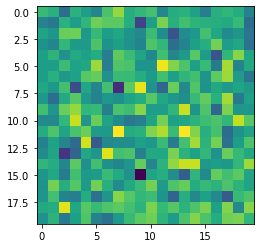

In [144]:
#Showing the EdU channel images by lowest EdU to highest
indices = np.array(df.sort_values(by=['EDU pi']).index) #sort cells by smallest value of EdU
# I need to make the crops smaller
for i in indices[:1]:
    print(df['EDU pi'][i])
    plt.imshow(edu_crops[i]);plt.show()

In [154]:
#Applying the S phase rule

#In the cell dataframe, we can now add the S phase label
#Apply a rule where every row where EdU is lower than 500 is the S-phase
background = 500 #pixel intensity
s_phase_cells = df.loc[df["EDU pi"] >= 500, "EDU pi"]
df["S_Phase"] = "False"
df.loc[df["EDU pi"].isin(s_phase_cells), "S_Phase"] = "True"

In [179]:
num_total_cells = df.S_Phase.value_counts()[0]+df.S_Phase.value_counts()[1]
num_in_s = df.S_Phase.value_counts()[1]
percentage_in_S = round(df.S_Phase.value_counts()[1]*100/num_total_cells,2)

print('According to the background rule, there are {} cells in the S phase.'.format(num_in_s))
print('With {} that is {}% of cells in S phase.'.format(num_total_cells,percentage_in_S))

According to the background rule, there are 59 cells in the S phase.
With 146 that is 40.41% of cells in S phase.


In [177]:
print(df)

                                         Gray cell img  integrated_int_DAPI  \
0    [[1929.5, 1830.0, 1902.5, 1897.25, 1901.25, 19...          5269.617500   
1    [[1993.25, 1940.25, 2048.25, 2016.5, 2037.5, 2...          3957.827500   
2    [[1996.0, 2008.5, 2050.75, 2045.75, 2075.25, 2...          4646.188272   
3    [[2154.0, 2154.5, 2159.75, 2158.0, 2171.25, 21...          4055.147500   
4    [[2046.5, 1992.0, 2005.5, 2111.25, 2118.75, 20...          5619.932099   
..                                                 ...                  ...   
141  [[2579.25, 2581.25, 2515.25, 2557.25, 2514.25,...          3162.954142   
142  [[2624.0, 2649.0, 2642.25, 2622.5, 2666.5, 265...          4805.642500   
143  [[2429.75, 2420.75, 2404.0, 2457.0, 2352.75, 2...          6257.024306   
144  [[2620.0, 2546.25, 2596.0, 2584.75, 2636.0, 27...          3314.396450   
145  [[2530.0, 2465.5, 2448.5, 2451.5, 2548.75, 250...          6603.452381   

          EDU pi  DNA_content S_Phase  
0    3291.8

In [ ]:
#Rules given by Dr Hochegger for the cell cycle classification

#G1: Cyclin A2 negative, EdU negative, DAPI<1.5
#S: EdU > background
#G2/M: DAPI (normalised) > 1.5, EdU < background, Cyclin > background

#Terminology
#DAPI is DAPI
#Cy5 is the EdU
#Alexa555 is PCNA
#Alexa488 is Cyclin A2